### Package Installation

In [ ]:
%pip install transformers==4.44.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 51.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3


In [ ]:
pip install datasets seqeval scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=6a3d80f22d3dac19da108a24e24f232d57249d311d1f05703b626308e3beea65
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

### Libraries

In [ ]:
from datasets import load_dataset, ClassLabel
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np
import torch
from seqeval.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from google.colab import userdata
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn as nn


### Loading Data & Preprocessing

In [ ]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")
dataset

README.md:   0%|          | 0.00/268 [00:00<?, ?B/s]

PLOD-CW-25-Train.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

PLOD-CW-25-Test.parquet:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

PLOD-CW-25-Val.parquet:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/150 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})

In [ ]:

label_list = list(set(tag for instance in dataset["train"]["ner_tags"] for tag in instance))
print(label_list)
num_labels = len(label_list)
num_labels

['O', 'B-LF', 'I-LF', 'B-AC']


4

In [ ]:
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}
def encode_labels(example):
    example["ner_tags"] = [label2id[label] for label in example["ner_tags"]]
    return example

encoded_dataset = dataset.map(encode_labels)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

### Load tokenizer and model

In [ ]:
model_checkpoint = "dmis-lab/biobert-base-cased-v1.2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config.id2label = id2label
model.config.label2id = label2id

In [ ]:

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = encoded_dataset.map(tokenize_and_align_labels, batched=True)
data_collator = DataCollatorForTokenClassification(tokenizer)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    precision = precision_score(true_labels, true_predictions)
    recall = recall_score(true_labels, true_predictions)
    f1 = f1_score(true_labels, true_predictions)
    accuracy = accuracy_score(true_labels, true_predictions)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    }

### Configuring Training Parameters

Label Distribution in Training Set:
B-AC           : 6626
O              : 62474
B-LF           : 3923
I-LF           : 9525


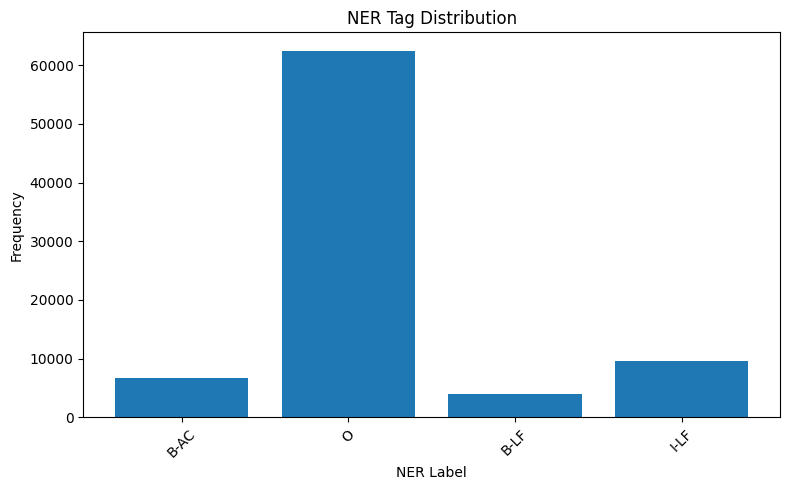


Imbalance Ratio (max/min): 15.93
⚠️ Dataset is likely imbalanced.


In [ ]:

all_labels = [label for example in encoded_dataset["train"]["ner_tags"] for label in example]


label_counts = Counter(all_labels)


label_names = [id2label[i] for i in range(len(id2label))]
label_freqs = {id2label[i]: label_counts[i] for i in label_counts}


print("Label Distribution in Training Set:")
for label, count in label_freqs.items():
    print(f"{label:15s}: {count}")


plt.figure(figsize=(8, 5))
plt.bar(label_freqs.keys(), label_freqs.values())
plt.xticks(rotation=45)
plt.title("NER Tag Distribution")
plt.ylabel("Frequency")
plt.xlabel("NER Label")
plt.tight_layout()
plt.show()

max_count = max(label_counts.values())
min_count = min(label_counts.values())
imbalance_ratio = max_count / min_count
print(f"\nImbalance Ratio (max/min): {imbalance_ratio:.2f}")


if imbalance_ratio > 3:
    print("⚠️ Dataset is likely imbalanced.")
else:
    print("✅ Dataset appears reasonably balanced.")


In [ ]:

total_labels = sum(label_counts.values())


num_labels = len(label2id)
weights = []

for i in range(num_labels):
    count = label_counts.get(i, 1)
    weight = total_labels / (count * num_labels)
    weights.append(weight)


class_weights = torch.tensor(weights, dtype=torch.float)
print(f"\nClass Weights:\n{class_weights}")



Class Weights:
tensor([0.3303, 5.2605, 2.1666, 3.1145])


In [ ]:
training_args = TrainingArguments(
    output_dir="./biobert-v1.2-base-cased-v1.2-ner",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    report_to="none"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device) if class_weights is not None else None

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        logits = outputs.logits
        labels = inputs["labels"]

        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights, ignore_index=-100)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
)

In [ ]:
train_result = trainer.train()
metrics = train_result.metrics
print("Training Loss:", metrics["train_loss"])
print(metrics)
log_history = trainer.state.log_history

print("Evaluation Metrics:")
for key, value in eval_result.items():
    print(f"{key}: {value:.4f}")


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.362300,0.320305,0.687679,0.884521,0.773778,0.894570
2,0.168600,0.322000,0.706981,0.883292,0.785363,0.900899
3,0.120600,0.350211,0.721393,0.890663,0.797141,0.908394
4,0.095700,0.377908,0.718533,0.890663,0.795392,0.909227
5,0.083600,0.430133,0.752101,0.879607,0.810872,0.913058
6,0.074300,0.439293,0.754237,0.874693,0.810011,0.912225


Training Loss: 0.1508768704732259
{'train_runtime': 399.791, 'train_samples_per_second': 30.016, 'train_steps_per_second': 1.876, 'total_flos': 1037579188897536.0, 'train_loss': 0.1508768704732259, 'epoch': 6.0}


Evaluation Metrics:
eval_loss: 0.4393
eval_precision: 0.7542
eval_recall: 0.8747
eval_f1: 0.8100
eval_accuracy: 0.9122
eval_runtime: 1.2541
eval_samples_per_second: 119.6090
eval_steps_per_second: 7.9740
epoch: 6.0000


### Training the Model

In [ ]:
print(train_result)


TrainOutput(global_step=750, training_loss=0.1508768704732259, metrics={'train_runtime': 399.791, 'train_samples_per_second': 30.016, 'train_steps_per_second': 1.876, 'total_flos': 1037579188897536.0, 'train_loss': 0.1508768704732259, 'epoch': 6.0})


### Evaluating Model Performance on test Data

In [ ]:

print("\nEvaluating on test set...")
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])

pred_ids = np.argmax(predictions, axis=2)


true_labels = []
true_predictions = []

for prediction, label in zip(pred_ids, labels):
    true_label = []
    true_pred = []
    for p, l in zip(prediction, label):
        if l != -100:
            true_label.append(id2label[l])
            true_pred.append(id2label[p])
    true_labels.append(true_label)
    true_predictions.append(true_pred)


print("\nClassification Report on Test Set:\n")
print(classification_report(true_labels, true_predictions))

precision = precision_score(true_labels, true_predictions)
recall = recall_score(true_labels, true_predictions)
f1 = f1_score(true_labels, true_predictions)
accuracy = accuracy_score(true_labels, true_predictions)

print(f"\nFinal Test Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"Accuracy : {accuracy:.4f}")
print(f"{token:15}  True: {id2label[label_id]:5}  Pred: {id2label[pred_id]:5}")



Evaluating on test set...



Classification Report on Test Set:

              precision    recall  f1-score   support

          AC       0.80      0.96      0.87       797
          LF       0.72      0.89      0.79       482

   micro avg       0.77      0.93      0.84      1279
   macro avg       0.76      0.92      0.83      1279
weighted avg       0.77      0.93      0.84      1279


Final Test Metrics:
Precision: 0.7687
Recall   : 0.9328
F1-score : 0.8428
Accuracy : 0.9348


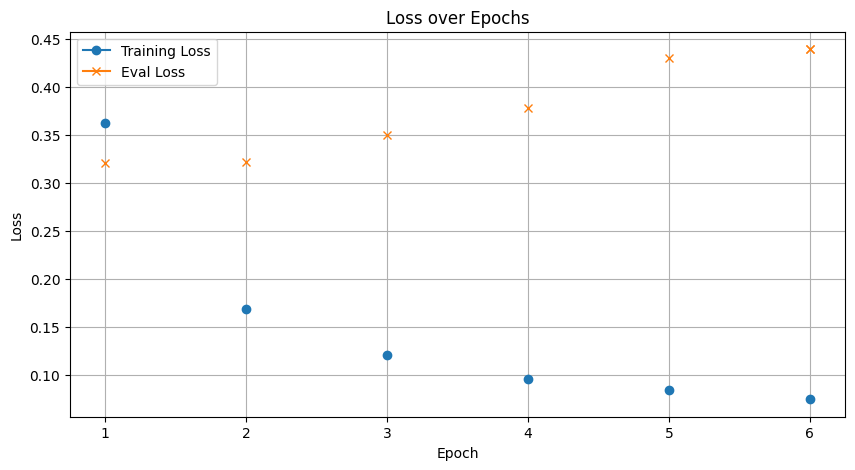

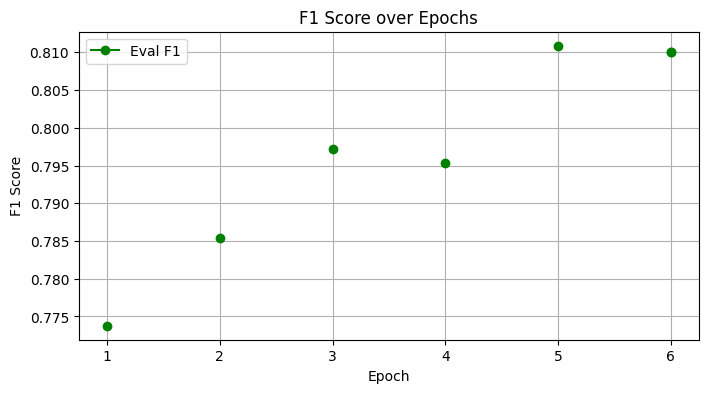

In [ ]:
import pandas as pd

def extract_log_metrics(log_histroy):
  logs = pd.DataFrame(log_history)
  logs = logs.dropna(axis=1, how='all')
  return logs
logs = extract_log_metrics(trainer.state.log_history)


plt.figure(figsize=(10, 5))
plt.plot(logs["epoch"], logs["loss"], label="Training Loss", marker='o')
if "eval_loss" in logs:
    plt.plot(logs["epoch"], logs["eval_loss"], label="Eval Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()


if "eval_f1" in logs:
    plt.figure(figsize=(8, 4))
    plt.plot(logs["epoch"], logs["eval_f1"], label="Eval F1", marker='o', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("F1 Score over Epochs")
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
#trainer.push_to_hub()

### Inferencing

In [ ]:
"""from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import torch

# Load model from local or Hugging Face Hub
model_path = "Lohit20/biobert-v1.2-base-cased-v1.2-ner"  # or "username/biobert-ner-model" if using Hub

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

# Set device (GPU if available)
device = 0 if torch.cuda.is_available() else -1

# Create inference pipeline
ner_pipeline = pipeline(
    "token-classification",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple",
    device=device
)

# User-provided tokens
tokens = [ "Abbreviations", ":", "HC", ",", "C", "-", "terminal", "receptor", "-", "binding", "domain", ";", "ka", ",", "association", "rate", "constant", ";", "kd", ",", "dissociation", "rate", "constant", ";", "KD", ",", "equilibrium", "dissociation", "constant", ";", "ND", ",", "nanodisc", ";", "Syt", ",", "synaptotagmin", ";", "WT", ",", "wild", "-", "type" ]

# Join tokens to string (since pipeline takes string input)
sentence = " ".join(tokens)

# Inference
results = ner_pipeline(sentence)

# Map predicted entity groups back to token positions
predicted_labels = []
for token in tokens:
    matched_entity = None
    for entity in results:
        if entity['word'] == token:
            matched_entity = entity['entity_group']
            break
    predicted_labels.append(matched_entity if matched_entity else 'O')

# Show labels per token
for token, label in zip(tokens, predicted_labels):
    print(f"{token}: {label}")
"""

'from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline\nimport torch\n\n# Load model from local or Hugging Face Hub\nmodel_path = "Lohit20/biobert-v1.2-base-cased-v1.2-ner"  # or "username/biobert-ner-model" if using Hub\n\ntokenizer = AutoTokenizer.from_pretrained(model_path)\nmodel = AutoModelForTokenClassification.from_pretrained(model_path)\n\n# Set device (GPU if available)\ndevice = 0 if torch.cuda.is_available() else -1\n\n# Create inference pipeline\nner_pipeline = pipeline(\n    "token-classification",\n    model=model,\n    tokenizer=tokenizer,\n    aggregation_strategy="simple",\n    device=device\n)\n\n# User-provided tokens\ntokens = [ "Abbreviations", ":", "HC", ",", "C", "-", "terminal", "receptor", "-", "binding", "domain", ";", "ka", ",", "association", "rate", "constant", ";", "kd", ",", "dissociation", "rate", "constant", ";", "KD", ",", "equilibrium", "dissociation", "constant", ";", "ND", ",", "nanodisc", ";", "Syt", ",", "synaptotagmin"